# Gaussian process regression (GPR) in F3DASM

## 0. Goal of this notebook
This notebook serves to answer the following questions in order:
1. Which Python packages do I need to import in order to perform GPR in F3DASM, and why?
2. How do I define an analytic data source and generate training data for GPR?
3. What are the hyperparameters that GPR uses and do I define them?
4. How do I train a GP regressor and evaluate the subsequent surrogate model?
5. Which error metrics are used to determine the quality of a GP surrogate model?

## 1. Package dependencies

We first import the `f3dasm` library, which serves as the framework for doing GPR.

In [1]:
import f3dasm

2023-03-08 18:50:34.241555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 18:50:34.372766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 18:50:34.372787: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 18:50:35.183527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


The GPR pipeline in F3DASM is based on the `pytorch` framework. As such, we need to import these packages:

In [2]:
import torch, gpytorch

Lastly, we need to import the following packages to do the necessary intermediate math and visualization.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 2. Training data

In this tutorial, we start by looking at a simple 1D regression problem with an analytic training data source.


### 2.1 Analytic data source
The F3DASM provides a readily available library of analytic functions. We can pick a function and instantiate it as follows:

In [4]:
dimensionality = 1

fun = f3dasm.functions.AlpineN2(
    dimensionality=dimensionality,
    scale_bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    )

2023-03-08 18:50:37.878005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 18:50:37.878379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-08 18:50:37.878440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-03-08 18:50:37.878487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-08 18:50:37.878531: W tensorflow/compile

Let's plot the function.

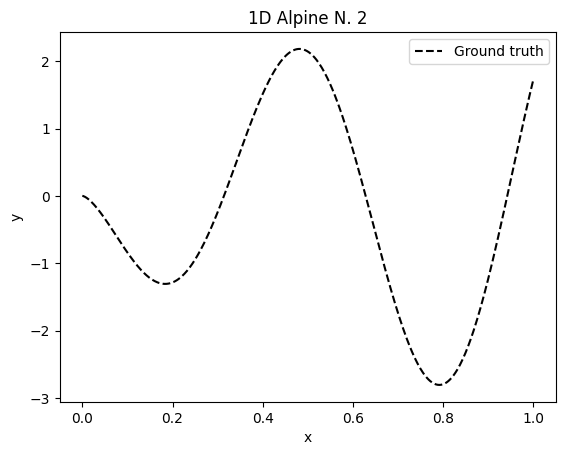

In [5]:
x_plot = np.linspace(0, 1, 500)[:, None] 
y_plot = fun(x_plot)

## Initialize plot
f, ax = plt.subplots(1, 1)

## Plot ground truth as black dashed line
ax.plot(x_plot, y_plot, 'k--')

## Add labels, legend and title
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ground truth'])
plt.title('1D ' + fun.name)

plt.show()

### 2.2 Generating the training data

F3DASM provides an interface for different sampling strategies. In our case, we can use it to generate the training data for GPR.

Let's first specify some values pertaining to the training data:

In [6]:
## Number of training data points
numsamples = 5

## Seed provided to the training data sampler for reproducibility
seed = 123
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)

## Does the data contain aleatoric uncertainty?
noisy_data_bool = False

Next, we define the design space, the sampler, and create the training data object.

In [7]:
## Define the domain in which the training data should be sampled from
parameter_DesignSpace: f3dasm.DesignSpace = f3dasm.make_nd_continuous_design(
    bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    dimensionality=dimensionality,
)

## Define the sampling method
sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace, seed=seed)

## Generate training samples with the sampler
train_data: f3dasm.design.ExperimentData = sampler.get_samples(numsamples=numsamples)
fun(train_data)

## Extracting input and output data
train_x = torch.tensor(train_data.get_input_data().values)
train_y = torch.tensor(train_data.get_output_data().values)

## Scaling the training data output
scaler = StandardScaler()
scaler.fit(train_y.numpy())
train_y_scaled = torch.tensor(scaler.transform(train_y.numpy()))

## Add Gaussian noise to the data if specified
train_y_scaled += noisy_data_bool * np.random.randn(*train_y_scaled.shape) * np.sqrt(0.04)

## Scaled data added to the training data
train_data.add_output(output=train_y_scaled)

In [8]:
train_data.data

,input,output
,x0,y
0,0.090251,-0.253773
1,0.638981,0.046532
2,0.790298,-1.553079
3,0.495575,1.577302
4,0.311189,0.183019


Let's see how the observed training data looks like.

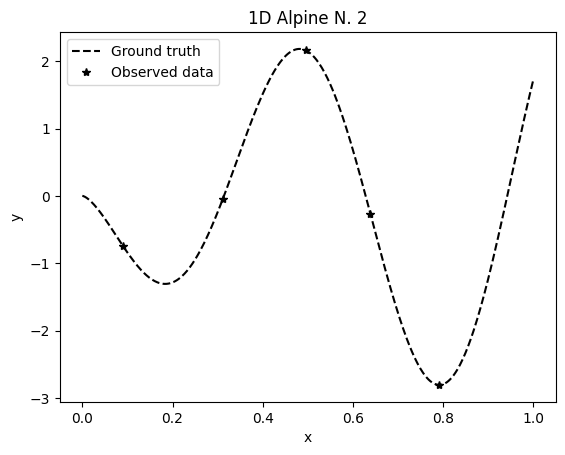

In [9]:
## Initialize plot
f, ax = plt.subplots(1, 1)

## Plot ground truth as black dashed line
ax.plot(x_plot, y_plot, 'k--')

## Plot training data as black stars
ax.plot(train_x, scaler.inverse_transform(train_y_scaled), 'k*')

## Add labels, legend and title
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ground truth', 'Observed data'])
plt.title('1D ' + fun.name)

plt.show()

## 3. Define the hyperparameters

In order for us to perform GPR, we first need to specify the necessary hyperparameters of the regression model.

### 3.1 Mean and covariance functions

The mean and covariance functions play a central role in GPR. Without loss of generality, it is customary to assume that the data has zero mean and therefore the mean function is customarily assumed to be such. [REFERENCE] 

Selecting the covariance function, or kernel, is subject to more freedom. The most popular choice is a (scaled) RBF kernel [REFERENCE], defined as
$$\text{RBF}(x,x')=A\exp\left(-\frac{|x-x'|^2}{2\ell^2}\right)$$

In [10]:
mean = gpytorch.means.ZeroMean()
kernel = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.RBFKernel())

### 3.2 Noise

It is possible that the training data contains aleatoric uncertainy, otherwise known as (data) noise. It is customary to assume this noise to be Gaussian; let $f$ be the ground truth mapping which takes input space values $x$ as an argument. Then, the input $x$ and output $y$ are related as follows:
$$y=f(x)+\varepsilon,\quad \varepsilon\sim\mathcal{N}(0,\sigma^2).$$
This is encoded into the likelihood as follows:

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

### 3.3 Likelihood optimizer 

The ultimate goal of GPR is to maximize the likelihood as a function of the model parameters. These maximizing model parameters are then used to construct the surrogate model of the objective function.

In this setup, the model parameters are:
- $A$: the kernel amplitude
- $\ell$: the kernel length scale
- $\sigma^2$: the data noise variance

The algorithm and corresponding hyperparameters to optimize the likelihood supplied as follows:

In [12]:
## The optimization algorithm used to maximize the likelihood
opt_algo = torch.optim.Adam

## Hyperparameters for above algorithm in dictionary format
opt_algo_kwargs = dict(lr=0.1)

## Number of steps the algorithm should take
training_iter = 50

## Should the algorithm output its progress?
verbose_training = True

## 4. Regression and prediction

We now have all the necessary ingredients to perform GPR. 

We first summarize all arguments that the regressor accepts. In F3DASM, this is encoded by means of a `f3dasm.machinelearning.gpr.Sogpr_Parameters` object. 

Note that all of the attributes have standard values: not all values and objects have to be supplied, as opposed to what is shown here.

In [13]:
param = f3dasm.machinelearning.gpr.Sogpr_Parameters(
    kernel=kernel,
    mean=mean,
    likelihood=likelihood,
    noise_fix=1 - noisy_data_bool,
    opt_algo=opt_algo,
    opt_algo_kwargs=opt_algo_kwargs,
    verbose_training=verbose_training,
    training_iter=training_iter,
    )


With the training data and the GPR parameters, we then instantiate a `f3dasm.machinelearning.gpr.Sogpr` object. 

This is an untrained regressor.

In [14]:
regressor = f3dasm.machinelearning.gpr.Sogpr(
    train_data=train_data,
    parameter=param,
)

Training the regressor will yield a surrogate:

In [15]:
surrogate = regressor.train()


Iter 1/50 - loss 14949.995 - 
Iter 2/50 - loss 8875.611 - 
Iter 3/50 - loss 4987.137 - 
Iter 4/50 - loss 2763.192 - 
Iter 5/50 - loss 1557.332 - 
Iter 6/50 - loss 908.117 - 
Iter 7/50 - loss 551.562 - 
Iter 8/50 - loss 349.282 - 
Iter 9/50 - loss 230.237 - 
Iter 10/50 - loss 157.555 - 
Iter 11/50 - loss 111.598 - 
Iter 12/50 - loss 81.580 - 
Iter 13/50 - loss 61.380 - 
Iter 14/50 - loss 47.413 - 
Iter 15/50 - loss 37.512 - 
Iter 16/50 - loss 30.336 - 
Iter 17/50 - loss 25.027 - 
Iter 18/50 - loss 21.026 - 
Iter 19/50 - loss 17.959 - 
Iter 20/50 - loss 15.572 - 
Iter 21/50 - loss 13.688 - 
Iter 22/50 - loss 12.182 - 
Iter 23/50 - loss 10.965 - 
Iter 24/50 - loss 9.970 - 
Iter 25/50 - loss 9.149 - 
Iter 26/50 - loss 8.465 - 
Iter 27/50 - loss 7.892 - 
Iter 28/50 - loss 7.407 - 
Iter 29/50 - loss 6.994 - 
Iter 30/50 - loss 6.641 - 
Iter 31/50 - loss 6.336 - 
Iter 32/50 - loss 6.073 - 
Iter 33/50 - loss 5.844 - 
Iter 34/50 - loss 5.643 - 
Iter 35/50 - loss 5.468 - 
Iter 36/50 - loss 5.313

This GP surrogate can then be sampled for its predictive distribution:

In [16]:
n_test = 500

## Get into evaluation (predictive posterior) mode
surrogate.model.eval()
surrogate.model.likelihood.eval()

## Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace, seed=0)
    test_x = torch.linspace(0, 1, n_test)
    
    observed_pred = surrogate.predict(test_x)
    exact_y = fun(test_x.numpy()[:, None])

Let's plot the predictive result:

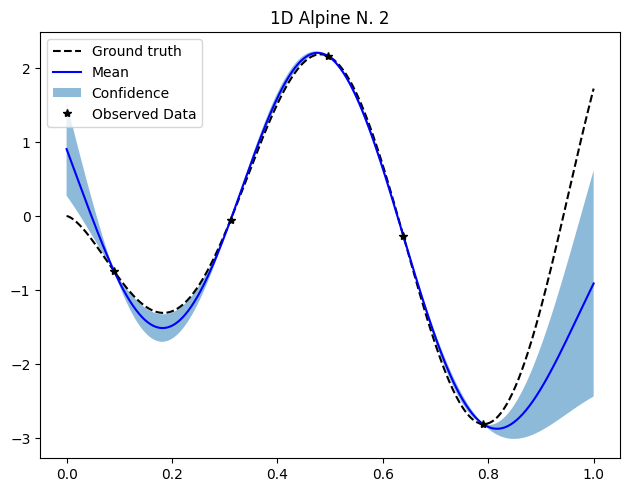

In [17]:
surrogate.plot_gpr(
        test_x=test_x, 
        scaler=scaler, 
        exact_y=exact_y, 
        observed_pred=observed_pred,
        train_x=train_x,
        train_y=torch.tensor(scaler.inverse_transform(train_y_scaled.numpy()))
        )

plt.title('1D ' + fun.name)
plt.show()

We can also plot the negative log marginal likelihood landscape of the GP model. 

Let's select $\ell$ and $A$ as the variable parameters, and we keep $\sigma^2$ at its fixed, optimized value. 

We can also observe the likelihood maximizer as located by the optimization algorithm `opt_algo`, as compared to the optimum found within this slice of the likelihood landscape.

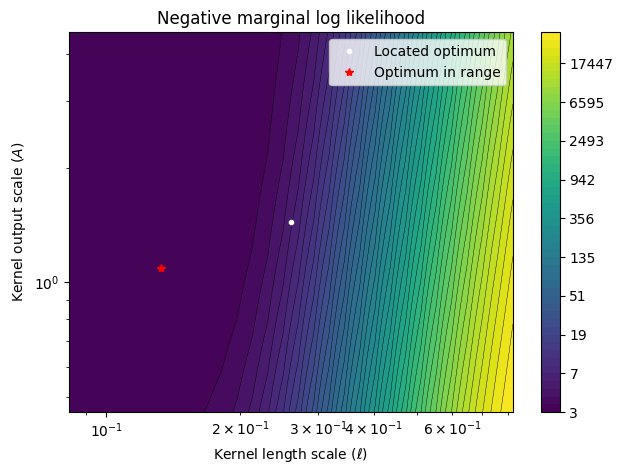

In [18]:
surrogate.plot_mll(
    train_x=train_x,
    train_y_scaled=train_y_scaled.flatten(),
)
plt.xlabel('Kernel length scale ($\ell$)')
plt.ylabel('Kernel output scale ($A$)')
plt.show()

## 5. Error metrics

We can now look into quantifying the performance quality of the surrogate model with respect to the objective.

### 5.1 $L^p$-distance

Let us calculate some error metrics, starting with the $L^1$, $L^2$ and $L^{\infty}$-distances. Recall that the $L^p$ distance between two vectors $y,y'\in\mathbb{R}^n$ is defined as
$$\|y-y'\|_{L^p}=\left(\sum_{k=1}^n|y_k-y_k'|^p\right)^{1/p}.$$

### 5.2 Mean $p$-error

The $L^p$-distances are closely related to the mean squared error (MSE) and mean average error (MAE) between $y$ and $y'$: $$\text{MSE}(y,y')=\frac1n\sum_{k=1}^n(y_k-y_k')^2=\frac1n\|y-y'\|_{L^2}^2$$
$$\text{MAE}(y,y')=\frac1n\sum_{k=1}^n|y_k-y_k'|=\frac1n\|y-y'\|_{L^1}$$
and in general, we can define the mean $p$-error (MpE) (with $p<\infty$) as
$$\text{MpE}(y,y')=\frac1n\|y-y'\|_{L^p}^p.$$
In the case of $p=\infty$, we define the MpE to equal the $L^\infty$-distance.

### 5.3 $p$-coefficient of determination

The sample mean of the data vector $y$ is defined as
$$\overline{y}=\frac1n\sum_{k=1}^ny_k.$$
With this, the sample mean absolute deviation (MAD) and variance can be calculated as
$$\text{MAD}(y)=\frac1n\sum_{k=1}^n|y_k-\overline{y}|=\text{MAE}(y,\overline{y}),\quad\text{Var}(y)=\frac1n\sum_{k=1}^n(y_k-\overline{y})^2=\text{MSE}(y,\overline{y}),$$
where we abuse the notation of $\overline{y}$ to mean $(\overline{y},\ldots,\overline{y})\in\mathbb{R}^n$ in the expressions on each right hand side.

Conventionally, the coefficient of determination, also called the $R^2$-score [REFERENCE], is defined as
$$R^2(y,y')=1-\frac{\text{MSE}(y,y')}{\text{Var}(y)}=1-\frac{\text{MSE}(y,y')}{\text{MSE}(y,\overline{y})}.$$
This score can be generalized by using the mean $p$-error instead of the mean squared error:
$$R_p^2(y,y')=1-\frac{\text{MpE}(y,y')}{\text{MpE}(y,\overline{y})},$$
from which we recover the usual $R^2$-score by setting $p=2$.

A summary of all aforementioned error metrics can be requested as such:

In [19]:
metrics_df = surrogate.gp_metrics(
    scaler=scaler,
    observed_pred=observed_pred,
    exact_y=exact_y.flatten(),
)

print(metrics_df)

                             1          2       inf
p-distance          163.990893  14.798874  2.630683
mean p-error          0.327982   0.438013  2.630683
sample p-deviation    1.236375   2.176641  2.500459
R^2_p                 0.734723   0.798766 -0.052080


## Exercises
1. Change the cosine GP kernel into an RBF kernel (`gpytorch.kernels.RBFKernel()`). What do you notice?
2. Change the function to regress from the AlpineN2 into the Schwefel function (`f3dasm.functions.Schwefel`). What do you notice?
3. Change the number of data points from `15` into a higher number $\le$`150`. Does the GP regress well?